# 基盤DS演習 第3回

※本演習資料の二次配布・再配布はお断り致します。



　今回の演習の内容は以下の3つである。

**DS3.0 | データクレンジング：データの整理**

**DS3.1 | 決定木 (decision tree) を用いた分類**

**DS3.2 | モデル選択 (model selection)**

　今回から、pandas や numpy に加えて機械学習用ライブラリである scikit-learn を用いて決定木を構築していく。

## DS3.0 | データクレンジング：データの整理

　今回は、タイタニック号の乗客のデータ `DS3_titanic.csv` を用いて、沈没事故の際にどのような乗客が生き残ったのかを予測する。
実はこの `DS3_titanic.csv` 、用いるデータの情報に一部抜けが存在しているため、まず**データクレンジング**と呼ばれる作業を行う（**補足資料 ※1**）。

　まず、OCW-iから `DS3_titanic.csv` を取得し、**`DS3_titanic.csv` をGoogle Colaboratoryにアップロードする**。アップロードが終わったら、どんな情報が含まれているデータなのか見てみよう。

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("DS3_titanic.csv")
pd.set_option("display.max_columns", None) # 全ての列を表示するための設定
print(df.head())                           # 最初の5データのみを表示する

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


　このデータには、生き残ったかどうかを示す`Survived`と、各乗客の情報が記されている。

　今回は簡単のために、乗客の情報は`Pclass`, `Sex`, `Age`, `Fare`の4種類のみを説明変数 (explanatory variables) として使うことにして、細かく見てみる。

In [3]:
# dfの中身を書き換えずにXを書き換える場合は.copy()を付ける
X = df[["Pclass", "Sex", "Age", "Fare"]].copy() # attributes (explanatory variables)
y = df["Survived"] # class label

　まず、ほとんどの機械学習のモデルは説明変数や目的変数 (class label) を**数値**で受け取るので、性別を数値に変換する。このデータでは性別は2種類しかないので、0/1の2値に変換しよう。

In [3]:
# 「"male"だったら1、そうでなければ0」という配列を作成し、X["Sex"]に代入する
X_sex_new = X["Sex"].apply(lambda x: 1 if x == 'male' else 0) # X["Sex"]自体は書き変わらないので注意 
X["Sex"] = X_sex_new                                          # 代入することで書き換える

In [4]:
print(X.head()) # Sexが0/1になっていることを確認する

   Pclass  Sex   Age     Fare
0       3    1  22.0   7.2500
1       1    0  38.0  71.2833
2       3    0  26.0   7.9250
3       1    0  35.0  53.1000
4       3    1  35.0   8.0500


　次に、明らかな値の間違いがないか確認するために、年齢のヒストグラムを描画してみる。

[]

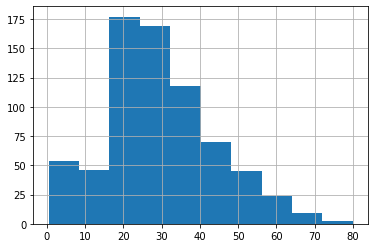

In [5]:
import matplotlib.pyplot as plt 
X["Age"].hist()
plt.plot()

　最大が0才から80才程度なので、どうやら変な値は入っていないようだ。

　次に、全ての説明変数について、値の欠損が存在しないか確認する。以下のコードで実行する `describe()` メソッドは、各数値型の特徴量の記述統計量を出力する。

In [6]:
print(X.describe())

           Pclass         Sex         Age        Fare
count  891.000000  891.000000  714.000000  891.000000
mean     2.308642    0.647587   29.699118   32.204208
std      0.836071    0.477990   14.526497   49.693429
min      1.000000    0.000000    0.420000    0.000000
25%      2.000000    0.000000   20.125000    7.910400
50%      3.000000    1.000000   28.000000   14.454200
75%      3.000000    1.000000   38.000000   31.000000
max      3.000000    1.000000   80.000000  512.329200


　ここで注目すべきは、**`Age`の`count`が他の件数と異なり、714となっている**。 `describe()` メソッドでは、**欠損していないデータの数**が `count` に表示されるため、年齢情報には欠損値が存在していることを示唆している。

　それでは、実際に欠損値を探してみる。値が欠損しているかどうかの判定は`isna()`で行うことができる(IS Not A number の略である)。

In [7]:
print(X["Age"].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: Age, Length: 891, dtype: bool


　しばしば`True`が表示されており、値の欠損が確かに存在していることがわかる。
どんなデータで欠損が発生しているか見てみよう。

In [8]:
print(X[X["Age"].isna()]) # Ageが欠損しているデータを全て抜き出す

     Pclass  Sex  Age     Fare
5         3    1  NaN   8.4583
17        2    1  NaN  13.0000
19        3    0  NaN   7.2250
26        3    1  NaN   7.2250
28        3    0  NaN   7.8792
..      ...  ...  ...      ...
859       3    1  NaN   7.2292
863       3    0  NaN  69.5500
868       3    1  NaN   9.5000
878       3    1  NaN   7.8958
888       3    0  NaN  23.4500

[177 rows x 4 columns]


　多くの学習手法は、全てのデータが埋まりきっていることを前提としているため、欠損値を含むデータを除外する、あるいはこれらの欠損値をなんらかの値で補填する必要がある。

　ここでは、（極めて雑な処理なのだが）平均値で年齢を埋めてしまうことにする。欠損値を埋める、という操作は`fillna()`という関数で行うことができる。

In [9]:
ave_age = X["Age"].mean()
X["Age"] = X["Age"].fillna(ave_age) 

In [10]:
print(X.describe())

           Pclass         Sex         Age        Fare
count  891.000000  891.000000  891.000000  891.000000
mean     2.308642    0.647587   29.699118   32.204208
std      0.836071    0.477990   13.002015   49.693429
min      1.000000    0.000000    0.420000    0.000000
25%      2.000000    0.000000   22.000000    7.910400
50%      3.000000    1.000000   29.699118   14.454200
75%      3.000000    1.000000   35.000000   31.000000
max      3.000000    1.000000   80.000000  512.329200


　これでデータクレンジングが完了した。

　最後に、この後の評価の為に、 `X` と `y` を**訓練データ (training data)** と**テストデータ (test data)** に分割する。これは、 scikit-learn の `train_test_split()` 関数が便利である。

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)
# test_size=0.2とすることで、全データの20%をテストデータにする

　これにより、データは**図3.1**のように分割された。

![図3.1](http://i.imgur.com/Y1DW99k.png)

**図3.1** 訓練データ (training data) とテストデータ (test data) への分割

## DS3.1 | 決定木を用いた分類

　決定木 (decision tree) とは、**図3.2**のように、**目的変数をよりキレイに分類できる説明変数と閾値で分岐させ続ける**ことで分類を行うモデルである。一般的には**図3.2**のように、3つ以上にいきなり分岐させることも決定木の範疇だが、これから利用するscikit-learnの決定木は2つに分岐させることにのみ対応している。

![図3.2](https://upload.wikimedia.org/wikipedia/ja/5/5d/Decision_tree_model_ja.png)

**図3.2** 決定木の例（Wikipedia 「決定木」 より抜粋）

### DS3.1.1 | scikit-learnを利用した決定木の構築と予測

　決定木は `DecisionTreeClassifier()` という名前で用意されているので、これを用いる。

In [12]:
from sklearn.tree import DecisionTreeClassifier 

In [13]:
model_full = DecisionTreeClassifier(random_state=0) # 再現性のため乱数のシードを固定

　上記のコードは見た目上は「`DecisionTreeClassifier()` という関数に `random_state=0` という引数を渡した返り値を `model_full` に格納した」ようになっているが、実際には**決定木を構築するための（からっぽな）モデルを準備して、model_fullという名前を付けた**と考えてほしい。

　これに対して、`model_full.fit()` を行うことで、実際に決定木を構築することができる。講義で分割の基準としてジニ係数（不純度、gini impurity）や情報利得 (information gain) を習ったが、ジニ係数を使った決定木の構築がデフォルト値となっている。

In [14]:
model_full.fit(X_train, y_train) # 訓練データの説明変数と目的変数を引数として与える

# 注意：以下のコードは間違い
#trained = model_full.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

　これだけで決定木の構築が完了した。 `model_full` 自体が書き換えられるので、代入を行う必要がないことに注意せよ。

　この学習済みモデルに対して、 `model_full.predict()` を行うことで訓練データの予測を行ってみる。

In [15]:
pred_y_train = model_full.predict(X_train) # 訓練データを予測してみる
print(pred_y_train) # 予測結果を表示してみる

[0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0
 0 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1
 0 0 0 0 1 0 0 1 0 0 0 0 

　出力結果は0と1の羅列だが、これは死亡=0、生存=1という意味で、今回説明変数として与えた4種類の情報から予測を行った結果を示している。

　次に、実際の生存結果 `y_train` と比較を行い、予測があっていたら `True` 、間違っていたら `False` とするような配列を作成しよう。

In [16]:
# NumPy配列の要素単位で結果が一致しているかどうかを比較している
prediction_result = (pred_y_train == y_train)
print(prediction_result)

140    True
439    True
817    True
378    True
491    True
       ... 
835    True
192    True
629    True
559    True
684    True
Name: Survived, Length: 712, dtype: bool


　非常に `True` が多く、正しく予測できている確率が高そうだ。最後に、正解率（＝ `True` の確率）を計算する。少しトリッキーだが、`True`/`False` の配列の平均値を計算することで、正解率を求めることができる。

In [17]:
# np.meanでは、True=1, False=0として解釈されるので
# meanを計算するだけでTrue率が求められる
accuracy = np.mean(prediction_result)
print(accuracy)

0.9789325842696629


　さて、決定木モデルは、学習したモデルを画像で出力することができる。
graphvizというツールの形式で出力されるため、`dot`というコマンドでPNG画像に変換する。

In [18]:
from sklearn import tree
tree.export_graphviz(model_full, out_file = "tree_full.dot", 
                     feature_names = X.columns,               # 特徴量名を表示させる
                     impurity = False,                        # 表示を簡単にする
                     class_names = ["Died", "Survive"])       # 予測結果をで表示させる

In [19]:
import graphviz

In [20]:
# graphvizを使ってpngなどに変換するおまじない、Google Colabでは最初から入っている
!dot -Tpng tree_full.dot -o tree_full.png # これで画像ファイルが作成できる
# 左のペインのファイルからダウンロード

Error: dot: can't open #
Error: dot: can't open これで画像ファイルが作成できる


　ファイルをダウンロードして、閲覧してみよう。**図3.3**のような（とんでもない）図が作成されているはずだ。
このように、一番上の部分から左右に2分割され続ける構造を「二分木」と言う。最初にも述べたが、scikit-learn の決定木は必ず二分木となる。

![図3.3](https://i.imgur.com/2VSkFzS.png)

**図3.3** 今回作成された決定木


-------
##### 課題 DS3.1
　先ほどは訓練データX_trainを使って、y_trainを予測した。

　同様にテストデータX_testの予測を行い、y_testとの比較を行うことで、予測正解率を**百分率で小数点以下2桁を四捨五入し、小数点以下1桁まで**答えよ。

In [18]:
## ヒントコード
pred_y_test = model_full.predict(X_test)
prediction_result_test = (pred_y_test == y_test)
accuracy_test = np.mean(prediction_result_test)
print("%.1f" % (accuracy_test*100),'%')

79.9 %


--------

### DS3.1.2 | よりシンプルな決定木の構築

　DS3.1.1で作成した決定木は非常に複雑であった。今度は、決定木の深さ（縦方向の大きさ）を制限することで、もっと簡単な決定木を作ってみよう。

　決定木の深さはモデルの引数で制限することが可能である。

In [22]:
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0) # 最大深さを3に制限する
model_simple.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

　model_fullの時と同様に、木構造を画像にしてみよう。

In [23]:
from sklearn import tree
tree.export_graphviz(model_simple, out_file = "tree_simple.dot", 
                     feature_names = X.columns, 
                     impurity = False, 
                     class_names = ["Died", "Survive"])

In [24]:
# graphvizを使ってpngなどに変換、Google Colabでは最初から入っている
!dot -Tpng tree_simple.dot -o tree_simple.png # これで画像ファイルが作成できる

Error: dot: can't open #
Error: dot: can't open これで画像ファイルが作成できる


　`tree_simple.png` も画像ファイルを開いて目視してみよう。
こちらは木の深さ（一番上から一番したまでの経路の長さ）が3に制限されているので、比較的わかりやすい図になっている。

![図3.4](https://i.imgur.com/aZCijPb.png)
**図3.4** 深さを制限した決定木

------
##### 課題 DS3.2

　**図3.4**の決定木を言葉で表現してみよう。例えば、一番下の段、右から4番目は「男性で、年齢が14才以下で、1等室か2等室の乗客は11人中11人生存している」という意味である。

　**一番下の段、左から3番目**について、「～～で、～～～で、～～～～の乗客は92人中57人生存している」と文章で記述せよ。

In [25]:
一番下の段、左から3番目について、「女性で、1等室と2等室以外で、船賃が23.35以下の乗客は92人中57人生存している」と文章で記述せよ。

SyntaxError: invalid character in identifier (<ipython-input-25-7e4565fea43e>, line 1)

------
##### 課題 DS3.3

　以下のコードの`__xxxxx__` 、`__yyyyy__` 、`__zzzzz__` を埋めて、確かに条件に該当する人が92人いることを確認せよ。

In [26]:
selection = X_train[__xxxxx__ <= 0.5]
selection = selection[__yyyyy__]
selection = selection[__zzzzz__]
print(len(selection))

NameError: name '__xxxxx__' is not defined

In [19]:
selection  = X_train[X_train['Sex'] <= 0.5]
selection = selection[selection['Pclass'] >= 2.5]
selection = selection[selection['Fare'] < 23.35]
print(len(selection))

92


------
##### 課題 DS3.4

　`model_simple` について、訓練データ `X_train` 、`y_train` に対して予測を行った時の正解率を計算し、訓練データに対する正解率は、 `model_full` と `model_simple` どちらの方が高いか述べよ。

　同様にテストデータ `X_test` 、`y_test` に対して予測を行った場合は、 `model_full` と `model_simple` どちらの方が正解率が高いか答えよ。

## ヒントコード
pred_y_test = model_full.predict(X_test)
prediction_result_test = (pred_y_test == y_test)
accuracy_test = np.mean(prediction_result_test)
print("%.1f" % (accuracy_test*100),'%')

In [28]:
pred_y_train_simple = model_simple.predict(X_train)
prediction_result_train_simple = (pred_y_train_simple == y_train)
accuracy_train_simple = np.mean(prediction_result_train_simple)
print('%.1f' % (accuracy_train_simple*100),'%')

82.7 %


In [29]:
pred_y_test_simple = model_simple.predict(X_test)
prediction_result_test_simple = (pred_y_test_simple == y_test)
accuracy_test_simple = np.mean(prediction_result_test_simple)
print('%.1f' % (accuracy_test_simple*100),'%')

81.0 %


------------

### DS3.1.3 | 交差検証法 (cross validation) を用いた2つのモデルの評価 (model assessment)

　課題DS3.4は、「訓練データに対する正解率」と「テストデータに対する正解率」それぞれを比較する問題であったが、どちらの方が重要だろうか。

　講義でも学んだように、母集団 (population) に対する平均的な予測精度（これを**汎化性能 (generalization performance)** と呼ぶ）が**高い方が利用価値の高い**モデルであるはずであり、**テストデータに対する性能で汎化性能を推定**している。
つまり、**「テストデータに対する正解率」でモデルを比較すべきである**。

　さらに、データのtraining-test分割を複数通り試すことで、**汎化性能を高精度に推定**することができる。その際に最も広く用いられるのが **$k$-分割交差検証法（$k$-fold cross validation, $k$-fold CV）**である。$k$-分割交差検証法では、**図3.4**のように、学習データを $k$ 個に分割（図の例では $k=4$ ）して、 $k-1$ 個のグループを学習用データに、1個のグループをテスト用データにした時の汎化性能を $k$ 回求め、その平均値（と標準偏差）でモデルの性能を評価する。また、$k$がデータ数と同じ場合（つまり、一つのデータをテスト
データにする場合）を特に**一個抜き交差検証法（leave-one-out cross validation, LOOCV）**という。

![図3.5](https://i.imgur.com/AUMBdH0.png)

**図3.5** 交差検証法 (cross validation) のデータ分割イメージ。4-fold 交差検証法を図示している。

　scikit-learnでは、交差検証法も `cross_val_score()` を用いることで簡単に実行することができる。関数の中でデータ分割を行うため、**`cross_val_score()` には全データを与える**ことに注意しよう。

In [30]:
from sklearn.model_selection import cross_val_score
import numpy as np

model_full = DecisionTreeClassifier(random_state=0)
full_cv_scores = cross_val_score(model_full, X, y, cv=10)
print(np.mean(full_cv_scores), "+-", np.std(full_cv_scores))

0.7710611735330836 +- 0.04461559297960239


In [31]:
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0)
simple_cv_scores = cross_val_score(model_simple, X, y, cv=10)
print(np.mean(simple_cv_scores), "+-", np.std(simple_cv_scores))

0.8136953807740325 +- 0.02804063097059579


　この結果から、木の深さを制限した決定木 `model_simple`の方が正解率が十分に高いことがわかる（**補足資料 ※2**）。

## DS3.2 | モデル選択 (model selection)

　DS3.1で、木の深さを制限した方が汎化性能が高いことが分かったが、ここでは**予測精度を最大化する最適な決定木の最大深さを探してみる**。このように、複数の学習モデルから最良のモデルを選ぶことを**モデル選択 (model selection)** と呼ぶ。

### DS3.2.1 | training-validation-test 分割

　講義で学んだように、モデル選択（例：決定木における「木の最大深」の最適化）においては、汎化性能を正しく推定するために訓練データ (training data) 、**検証データ (validation data)** 、テストデータ (test data) の3データに分割した上で、以下の手順を踏む（**補足資料 ※3**）。

* **モデル選択 (model selection)** ：検証データ (validation data) を最もよく予測できるモデルを選ぶ
* **モデルの評価 (model assessment)** ：最良モデルを使ってテストデータ (test data) を予測し、汎化性能を推定する

### DS3.2.2 | 交差検証法を用いたモデルの選択
　それでは、DS3.1節でも用いた交差検証法を用いて、決定木の深さの最大値はいくつにするのが最も良さそうか、確かめてみよう（このように、学習を行う前に指定しなければならない変数のことを**ハイパーパラメータ**と呼ぶ）。

　この場合、**テストデータはあらかじめ除外した上で、訓練データと検証データの分割を交差検証法によって複数回試す**のが良い（**図3.6**）。

![図3.6](https://i.imgur.com/2i5U90o.png)

**図3.6** モデル選択時の交差検証法 (cross validation) のデータ分割イメージ。20%をテストデータにしたうえで、4-fold 交差検証法を行った場合を図示している。

　**図3.6**のデータ分割を実現するには、まず`train_test_split()` を行い、`X_train`, `y_train`, `X_test`, `y_test`に分割した上で、`X_train`と`y_train`をつかって交差検証法を行えばよい。

　ハイパーパラメータの探索時には交差検証法は極めてよく利用されるため、scikit-learnでは `GridSearchCV()` 関数が用意されている。以下では、これを用いて最適なハイパーパラメータを探索している。

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# test_size=0.2とすることで、全データの20%をテストデータにする

In [38]:
# 辞書型が1つ入った配列
param_grid = [  
  {
    "max_depth": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
  }
]
template_model = DecisionTreeClassifier(random_state=0)          # 未学習の決定木を準備する
grid_search_dt = GridSearchCV(template_model, param_grid, cv=10) # 10-fold CVをしながら最適なモデルを決定する、という指令を与える
grid_search_dt.fit(X_train, y_train)                             # 実際にデータを与え、内部でtraining-validation分割を行いながら最適なモデルを決定する
print(grid_search_dt.best_params_)                               # 最適なハイパーパラメータを確認する
print(grid_search_dt.best_score_)                                # 最適なハイパーパラメータの時のvalidationセットの予測精度を表示する

{'max_depth': 5}
0.8104655712050078


　この結果から、titanicデータに対する予測では、木の深さの最大値を4にした時に最も正解率が高くなることがわかった。新しいデータを予測する時には、このモデルを使うと良さそうだ。

　最後に、このモデルでテストデータを予測することで、汎化性能を推定しよう。


In [39]:
pred_y_test = grid_search_dt.predict(X_test)
prediction_result = (y_test == pred_y_test)
accuracy = np.mean(prediction_result)
print(accuracy)

0.8156424581005587


　以上で、交差検証法を用いたモデル選択を行い、最良モデルの汎化性能を推定することができた（**補足資料 ※4**）。


　今回の授業では、2種類の交差検証法 cross validation の説明を行ったが、どう使い分ければよいか理解できただろうか。**自分が作ることのできる「学習器とハイパーパラメータの組み合わせ」が複数あるなら、trainとvalidationを使って自分の最強モデルを決め**、**他人の手法と比較するときはtestデータを使って比較する**と考えておくと良い。

--------

##### 課題 DS3.5

　講義資料では、決定木の最大深さのみをいろいろ変化させて評価したが、これに加えて、`min_samples_leaf`という値も`1,2,3,4,5,6,7,8,9,10`の値の範囲で探索したい。

　まず、**min_samples_leafとはどういうパラメータか調べ、簡潔に答えよ**。

　次に、GridSearchCVを用いて、min_samples_leafも含めたパラメータ探索を行い、最良のモデルのmax_depthとmin_samples_leafの値、およびテストデータ予測時の正解率を答えよ。正解率は**百分率で小数点以下2桁目を四捨五入し、小数点以下1桁まで**答えること。

なお、実行結果の再現性を担保するため、`random_state` が記述された以下のコードを使用せよ。

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# データの生成
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# 探索するパラメータの設定
param_grid_2 = [
    {
        "min_samples_leaf": [x for x in range(1,11)]
    }
]

#10-fold CVをしながら最適なモデルを決定
grid_search_dt2 = GridSearchCV(DecisionTreeClassifier(random_state = 0),param_grid_2,cv = 10)
grid_search_dt2.fit(X_train,y_train)

# テストデータを用いた評価

pred_y_test_leaf = grid_search_dt2.predict(X_test)
pred_y_test_leaf_result = (pred_y_test_leaf == y_test)
min_leaf_accuracy = np.mean(pred_y_test_leaf_result)

print("%.1f" % ((min_leaf_accuracy)*100),"%")

83.8 %


-------

# レポート提出について



## レポートの提出方法

　レポートは**答案テンプレートを用い**、**1つのファイル（.doc, .docx, .pdf）**にまとめ、**学籍番号と氏名を確認の上**、**次回 基盤データサイエンス演習 の開始時刻までに東工大ポータルのOCW-iから提出**すること。
ファイルのアップロード後、OCW-iで「提出済」というアイコンが表示されていることを必ず確認すること。それ以外の場合は未提出扱いとなるので十分注意すること。
また、締め切りを過ぎるとファイルの提出ができないため、時間に余裕を持って提出を行うこと。


## 答案テンプレート

```
学籍番号:
名前:

課題 DS3.1
テストデータに対する正解率： ______ %

課題 DS3.2
____________で、____________で、____________の乗客は92人中57人生存している。

課題 DS3.3
__xxxxx__ = _________________
__yyyyy__ = _________________
__zzzzz__ = _________________

課題 DS3.4
訓練データに対する正解率は、 { model_full | model_simple } の方が良い。
テストデータに対する正解率は、 { model_full | model_simple } の方が良い。

課題 DS3.5
min_samples_leafとは：

最良モデルのmax_depth：
最良モデルのmin_samples_leaf：
最良モデルのテストデータ正解率： _____ %

```

## 補足資料

### ※1 データクレンジングの重要性

　データサイエンスを行う場合、第2回の講義で利用したirisのように全てのデータが完全に埋まっていることはあまり多くなく、記載されている情報すら誤りが含まれている。

　例えば、欠損は以下のようなときに発生する。
* 必須登録項目ではない
  * 例：SNSにおける生年月日
* 選択肢に「不明」が含まれる
  * 例：性別（LGBT等への配慮）

　また、情報の誤りは以下のケースが考えられる。
* 意図的な虚偽申告
  * 例：小学生のtwitter利用（現在twitterは13才以下利用禁止）
  * 例：1人暮らし女性などの通販サイトの「男性」としての登録（防犯上の理由）
* 初期設定が原因である虚偽申告
  * 都道府県（初期設定が北海道で、変更せずそのまま登録）
* 複数人が同一アカウントを利用している
  * 母親のアカウントで家族全員分の通販を処理
  
　このため、ユーザが自己申告する情報を鵜呑みにせず、購入履歴などから情報を推定することも重要になったりする。

　また、機械的なものであっても、センサーの不具合や故障によって、欠測や誤った計測値の出力は発生するため、こちらもやはり前後のデータから誤りが発生していないか判定することが必要になる。

　これらのデータの「汚れ」をキレイにすることは**極めて重要**であり、かつ極めて地味な作業でもある。



### ※2 model_simpleはmodel_fullよりも「有意」に汎化性能が高いのか？

　model_simpleの方がmodel_fullよりも予測精度の平均が高いことが分かったが、これは偶然なのだろうか、それとも有意に差があるのだろうか。ウィルコクソンの符号順位検定を行うことで、model_simpleがmodel_fullに勝っているかどうか統計的に評価してみよう。


　ここでは、帰無仮説を「model_simpleの汎化性能はmodel_fullの汎化性能よりも高くない」、有意水準を$\alpha=0.05$とする。
ウィルコクソンの符号順位検定は、SciPyというパッケージを利用することで行うことが出来る。

In [40]:
from scipy import stats

model_full = DecisionTreeClassifier(random_state=0)
model_simple = DecisionTreeClassifier(max_depth=3, random_state=0)
full_cv_scores = cross_val_score(model_full, X, y, cv=10)
simple_cv_scores = cross_val_score(model_simple, X, y, cv=10)


print(stats.wilcoxon(full_cv_scores, simple_cv_scores, alternative="less"))

WilcoxonResult(statistic=7.5, pvalue=0.0185546875)


　`pvalue=0.0294...`という結果より、帰無仮説が棄却され、model_simpleはmodel_fullに有意に汎化性能が高いことが示された。

### ※3 なぜtraining-validation-test分割は必要か？

　講義でもtraining-validation-test分割の必要性の議論はあったと思うのだが、一応ここでも補足資料として記載しておくことにする。

　こんなことを考えてみよう。世界で数学選手権が行われ、日本でその国内予選がある。競技参加者は同じ参考書を使って勉強し、国内予選に出場し、そこで最も良い成績を収めた選手1名が日本代表として世界大会で各国の代表と競う。

　国内予選では問題セット $V$ が出題されたとすると、総合的な実力もさることながら、たまたま $V$ が得意な問題だった選手は良い成績を収めやすい。しかし、世界大会で出題される問題セット $T$ は問題セット $V$ とは異なる問題なので、もし難易度が全く一緒だったとしても、国内予選よりもわずかに悪い成績に落ち着く可能性が高いだろう。

　関係性がわかっただろうか。**多数の国内予選出場者が多数のモデルに対応**し、予選出場者の**参考書が訓練データ**、**国内予選の問題セット $V$ が検証データ**、**世界大会の問題セット $T$ がテストデータ**である。モデル選択によってえらばれた代表モデルは**検証データを予測するのが得意だったから**選ばれた可能性があり、**汎化性能（任意の問題に対する成績の期待値）よりも高いことが多い**のである。

### ※4 検証データよりもテストデータの予測精度が良くなっている？

　補足資料 ※3 で議論したように、一般的にはモデル選択を行うとわずかに**検証データの方がテストデータよりも予測精度が高くなる**はずである。しかし、実際に `GridSearchCV()` を使って、検証データ、テストデータに対する予測精度をそれぞれ眺めてみると、テストデータに対する予測精度の方がわずかに高いことがある。なぜだろうか？

　これは、scikit-learnの`GridSearchCV()`が、

* 訓練データで学習を行いながら、最適なハイパーパラメータを探索する
* 最適なハイパーパラメータを用いて、**訓練データ+検証データで学習を行う**

という動作を行うためである。学習に用いられるデータ数が多くなることで、テストデータの予測精度が向上している可能性がある。
